## Stock Price Prediction

The stock market is a trillion-dollar industry with lots of potential for investors. Traders have made unbelievable amounts of profit by getting in on the right stock at the right time. But identifying the right time is never a straightforward event.

Imagine you want to make money trading stocks, and you only want to buy stocks you can trade for higher. As a day trader, you want to only buy a stock at the start of trade each day only if you're certain the price will increase before close of day. How can you be sure there'll be a price increase?

That is the question this project seeks to answer. How can you know for certain that the price of a stock will increase tomorrow, so you can plan to buy it at the start of trade tomorrow?

A classification algorithm will be built to answer this question. The algorithm's goal will be to predict if the price will go up (not by how much it went up). A deicison to buy a stock will then be based on whether the price is predicted to go up or not.

Although you may not be able to tell just how much profit you'd be making from a trade, this algorithm should help you make a profit on every trade. 

### The Data

The yfinance API is third-party API that draws daily stock price data from the Yahoo Finance platform, and has a record for the entire historical price data of most stocks. This is where the data for this project will come from. First, we'll download the data. Then, we'll explore it and set it up for our machine learning model. 

For this specific project, we'll be working with the Microsoft (MSFT) stock price data from when it began trading to present. Once the data is downloaded, it'll be saved locally to keep us from calling the API every time we need it.

In [1]:
# Installing relevant packages

import yfinance as yf
import pandas as pd
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# The data file will be read from the API and saved locally for easy access in the future

DATA = "msft_data.json"

if os.path.exists(DATA):
    # If the data already exists locally, read the stored data
    with open(DATA) as f:
        msft_data = pd.read_json(DATA)
else:
    # If the file doesn't already exist, download it from the yfinance API and save to json
    msft = yf.Ticker("MSFT")
    msft_data = msft.history(period="max")
    msft_data.to_json(DATA)

### Data Exploration

In [3]:
# Display the microsoft stock price history
msft_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


In [4]:
msft_data.shape

(9049, 7)

From the above, we make some important findings. First, each row of data stands for a day of trading. This means a row is tied to every trading day (stocks don't trade on weekends) since the stock was listed. There are 5 important columns in this data:

+ Open - The price the stock opened trading at
+ High - The highest price the stock got to during trading hours that day
+ Low - The lowest price the stock got to during trading hours that day
+ Close - The closing stock price for the day
+ Volume - The number of shares traded that day

Next, we'll plot the data to visualize how the stock price has changed over time. This will be done using just the closing price of every trading day.

<AxesSubplot:>

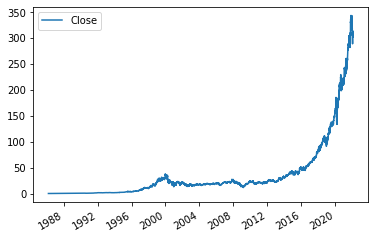

In [5]:
# Visualizing the microsoft stock price changes

msft_data.plot.line(y="Close", use_index=True)

<AxesSubplot:>

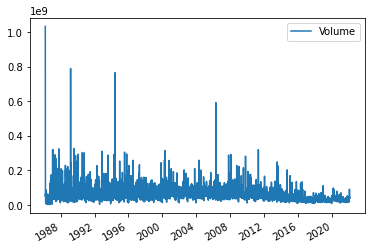

In [6]:
msft_data.plot.line(y="Volume", use_index=True)

The above tells us the Microsoft price has been on a steady upward trajectory for the last 30 years. Also interesting is the clear lack of relationship between trading volume and the microsoft stock prices. 

Conclusion: You should have bought the stock when you had the chance.

### Data Preparation

The goal of this exercise is to make binary predictions about the price of the microsoft stock. This means we should be able to tell whether the price of the stock goes up tomorrow, using today's data.

To begin, we need to determine the days during which the prices went up or down. Then, we need to create a target variable which will be `1` for days when the prices went up, and `0` for days when the price dropped.

Finally, we'll shift the data "forward" by one day, so it can be used to predict the target price. The idea is that the data from the previous day will be used for the prediction of each day's target variable. Shifting the data forward will keep us from predicting today's target using today's data.

#### Setting up the training dataset

This will be done in two steps:

+ First, we'd copy the existing `close` values into a new dataset. This data column will be renamed `Actual Close` to ensure it is retained after shifting the data forward by one day. 

+ Next, we'll use the pandas `rolling` method to compare every row of data with the row before it. This method picks each pair of rows. We will be returning 1 for everytime the day's close value is greater than the one before it.

+ Next, we'll use the pandas `shift` method to shift the values forward by one row. This method will, for instance, move the values from the trading day `1986-03-13` to `1986-03-14`, thus ensuring we're making predictions the future from the past. This will be done in a new dataset for organization purposes

+ Finally, we'll combine both datasets using the `join` method. We will also be dropping the first trading day data as there are no available values for prediction using our model

In [7]:
# Select and store the Close column to a new dataframe
data = msft_data[["Close"]]

# Rename the column to 'actual_close' so it doesn't get mixed up
data = data.rename(columns={'Close': "Actual_Close"})

In [8]:
# Create the target variable using the rolling method
data["Target"] = msft_data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']

In [9]:
data.head()

,Actual_Close,Target
1986-03-13,0.061378,NaN
1986-03-14,0.063570,1.0
1986-03-17,0.064667,1.0
1986-03-18,0.063022,0.0
1986-03-19,0.061926,0.0


In [10]:
# Shift stock prices foward by one day to ensure today's values only 
# predict tomorrow's target
msft_forward = msft_data.copy()
msft_forward = msft_forward.shift(1)

In [11]:
msft_forward.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0
1986-03-19,0.064667,0.065215,0.062474,0.063022,6.776640e+07,0.0,0.0


In [12]:
# Select the first 5 columns of our dataset for our predictor values
predictors = list(msft_data.columns[:-2])

# Combine the two newly created datasets for our training data
data = data.join(msft_forward[predictors]).iloc[1:]

In [13]:
data.head()

,Actual_Close,Target,Open,High,Low,Close,Volume
1986-03-14,0.063570,1.0,0.055898,0.064119,0.055898,0.061378,1.031789e+09
1986-03-17,0.064667,1.0,0.061378,0.064667,0.061378,0.063570,3.081600e+08
1986-03-18,0.063022,0.0,0.063570,0.065215,0.063570,0.064667,1.331712e+08
1986-03-19,0.061926,0.0,0.064667,0.065215,0.062474,0.063022,6.776640e+07
1986-03-20,0.060282,0.0,0.063022,0.063570,0.061378,0.061926,4.789440e+07


### Machine Learning Model Building

It's finally time to build the machine learning model. The `Random Forest Classifier` will be used for this prediction. Thanks to its ability to pickup non-linear relationships in data, this is a great model for our data type.

Because this is a time series data, we can't just split the training and testing data using sklearn's `train_test_split` module. This will split the data without regard for its sequential ordering, leading to leakage where the data from the future will be used to predict the past. For this same reason, we can't use cross validation modules for our model building.

Instead, the training and testing data will be split sequentially. We'll begin by leaving only the last 100 rows of data for our test dataset.

In [14]:
# Import relevant packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

In [15]:
# Splitting the train and test data
train = data.iloc[:-100]
test = data.iloc[-100:]

# Creating the randomforest model with large numbers of predictors
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [16]:
# Evaluate the model performance

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
print(f"The precision score of the model is: {precision_score(test['Target'], preds)}")
print(f"The accuracy score of the model is: {accuracy_score(test['Target'], preds)}")

The precision score of the model is: 0.5294117647058824
The accuracy score of the model is: 0.46


In [21]:
# Compare the number of times we would have traded vs days trading was profitable
print(f"Following this model, we would have traded {preds.sum()} times, although trading was profitable on {test['Target'].sum()} days out of {len(test)}.")

Following this model, we would have traded 17.0 times, although trading was profitable on 55.0 days out of 100.


The result here is indicative of how poor our model is. A precision score of 52.9% indicates that the model correctly predicts the days to trade ~53% of the time. This means we miss out on more than half the days we were supposed to trade. An accuracy score of 46% means the model is generally more inaccurate than accurate. 

<AxesSubplot:>

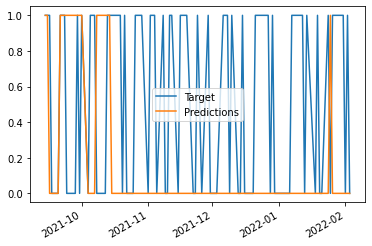

In [19]:
combined = pd.concat({"Target": test['Target'], "Predictions":preds}, axis=1)
combined.plot()

The above shows that our model was correct (accurately predicting the best times to purchase or sit back) for a few days in October of 2021. After this period, though, the model only forecasted against making a purchase. It was right just about 50% of the time.

### Backtesting

